# Rydiqule Performance #

The primary purpose of this notebook is to provide a sense of how solve times in rydiqule scale with problem size. It also provides a practical example of the advantages of using rydiqule for large numbers of semi-classical master-equation solving relative to other tools.

In [1]:
import rydiqule as rq
import numpy as np
import matplotlib.pyplot as plt
import time

## Steady-state solve time scaling versus basis size ##

We begin by showing how the solve time for a single set of Equations of Motion scales with the number of states in the basis $b$.

For this benchmark, we randomize each problem to be solved, ensuring that there are around $b*\log(b)$ couplings with a random coupling strength, and each state decays to the ground state with a random rate. All detunings are held to be 0.

In [2]:
def random_ss_sensor(n_states, n_couplings, rabi_bounds=[0.1,10], detuning_bounds=[0,0], decoherence_bounds=[0,0.5]):
    if type(n_states) is not int:
        n_states = n_states.item()
    s = rq.Sensor(n_states)
    
    decoherences = np.random.uniform(decoherence_bounds[0], decoherence_bounds[1], size=n_states)
    gamma = np.zeros((n_states, n_states))
    gamma[:,0] = decoherences
    s.set_gamma_matrix(gamma)
    
    possible_coups = np.array(np.triu_indices(n_states, 1), dtype=int).T
    idx = np.random.choice(np.arange(len(possible_coups)), n_couplings, replace=False)
    coups = possible_coups[idx]
    
    rabis = np.random.uniform(rabi_bounds[0], rabi_bounds[1], size=n_couplings)
    detunings = np.random.uniform(detuning_bounds[0], detuning_bounds[1], size=n_couplings)
    
    lasers = []
    for i in range(n_couplings):
        lasers.append({"states": (int(coups[i][0]), int(coups[i][1])), "rabi_frequency": rabis[i], "detuning": detunings[i]})

    s.add_couplings(*lasers)
    
    return s

To provide some statistical measure without making the notebook run too long in a single sitting, we average 4 runs per point.

In [3]:
n_sims = 4

n_states = np.array([2, 3, 4, 8, 16, 32, 64, 96])
n_couplings = np.array(n_states*np.log(n_states), dtype=int)
print(n_states)
print(n_couplings)

[ 2  3  4  8 16 32 64 96]
[  1   3   5  16  44 110 266 438]


In [4]:
times = np.zeros((n_sims, len(n_states)))

for j in range(len(n_states)):
    for i in range(n_sims):
        print(f'Solving {n_states[j]:d} states, round {i+1:d}/{n_sims:d}', end='\r')
        s = random_ss_sensor(n_states[j], n_couplings[j])
        tic = time.perf_counter()
        _ = rq.solve_steady_state(s)
        toc = time.perf_counter()
        times[i,j] = (toc - tic)

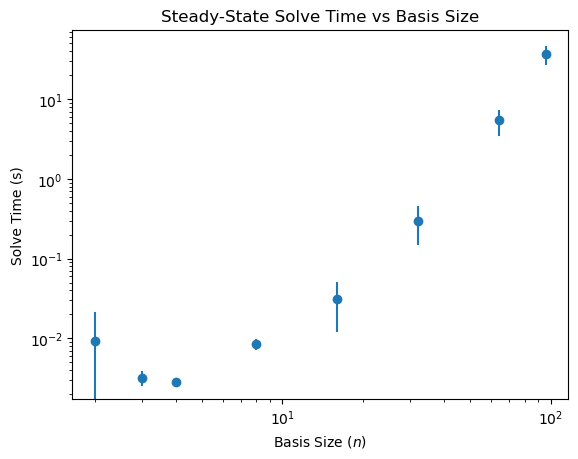

In [5]:
fig, ax = plt.subplots(1)

ave_times = times.mean(axis=0)
std_times = times.std(axis=0)

ax.errorbar(n_states, ave_times, yerr=std_times, fmt='o')
ax.set_title('Steady-State Solve Time vs Basis Size')
ax.set_xlabel('Basis Size ($n$)')
ax.set_ylabel('Solve Time (s)')
ax.set_yscale('log')
ax.set_xscale('log')

## Steady-state solve time scaling versus stack size ##

Here we see how solve time scales versus the number of Equations of Motion to be solved for a system with a basis size of 3. This is done by varying how many probe detuning points we sample.

In [6]:
couple = {'states': (1,2), 'rabi_frequency':2*np.pi*1, 'detuning':2*np.pi*0, 'label':'couple'}

sts = rq.Sensor(3)
sts.add_couplings(couple)
sts.add_decoherence((1,0), 2*np.pi*6.0666)
sts.add_decoherence((2,1), 2*np.pi*0.1)

In [7]:
n_sims = 4
ssize = np.array([2, 10, 20, 40, 80, 160, 300, 600, 1200, 2400, 4800, 10000])

In [8]:
times_stack = np.zeros((len(ssize), n_sims), dtype=float)

for i, p_pts in enumerate(ssize):
    for j in range(n_sims):
        probe = {'states': (0,1), 'rabi_frequency':2*np.pi*0.1,
                 'detuning':2*np.pi*np.linspace(-100, 100, p_pts), 'label':'probe'}
        sts.add_couplings(probe)
        tic = time.perf_counter()
        _ = rq.solve_steady_state(sts)
        toc = time.perf_counter()
        times_stack[i,j] = (toc-tic)

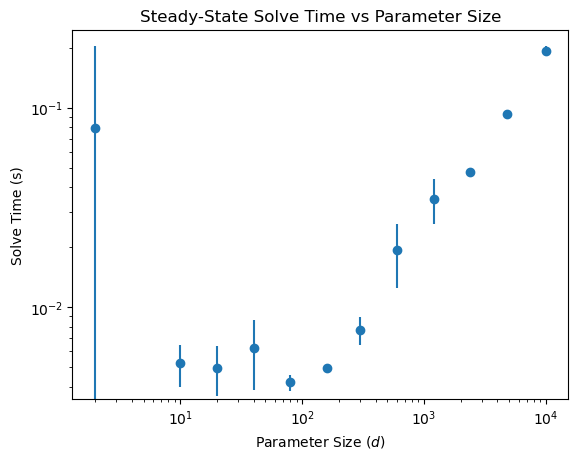

In [9]:
fig, ax = plt.subplots(1)

ave_times = times_stack.mean(axis=1)
std_times = times_stack.std(axis=1)

ax.errorbar(ssize, ave_times, yerr=std_times, fmt='o')
ax.set_title('Steady-State Solve Time vs Parameter Size')
ax.set_xlabel('Parameter Size ($d$)')
ax.set_ylabel('Solve Time (s)')
ax.set_yscale('log')
ax.set_xscale('log')

## Time-dependent solve times versus stack size ##

Here we repeat the test, but with a time-dependent coupling. Note that time-dependent solving is slower than steady-state by a fair bit. This is not aided by our insistence on allowing arbitrary python functions for the time dependence, which makes the back-end implementations tricky.

In [10]:
couple = {'states': (1,2), 'rabi_frequency':2*np.pi*1, 'detuning':2*np.pi*0, 'label':'couple',
          'time_dependence': lambda t: np.sin(2*np.pi*2*t)}

tts = rq.Sensor(3)
tts.add_couplings(couple)
tts.add_decoherence((1,0), 2*np.pi*6.0666)
tts.add_decoherence((2,1), 2*np.pi*0.1)

In [11]:
n_sims = 4
tsize = np.array([2, 10, 20, 40, 80, 160, 320])

Rydiqule's standard time-solving backend is scipy's `solve_ivp`.

In [12]:
ttimes_stack = np.zeros((len(tsize), n_sims), dtype=float)

for i, p_pts in enumerate(tsize):
    for j in range(n_sims):
        print(f'Solving {p_pts} detunings, round {j+1}/{n_sims}', end='\r')
        probe = {'states': (0,1), 'rabi_frequency':2*np.pi*0.1,
                 'detuning':2*np.pi*np.linspace(-100, 100, p_pts), 'label':'probe'}
        tts.add_couplings(probe)
        tic = time.perf_counter()
        _ = rq.solve_time(tts, end_time=10, num_pts=100)
        toc = time.perf_counter()
        ttimes_stack[i,j] = (toc-tic)

Rydiqule also has some support for a compiled version of `solve_ivp` provided by the `CyRK` package. It can be faster for some kinds of problems, but it is not compatible with all problems in rydiqule. For example, the optional `flat` argument used here provides the best performance, but is not compatible with doppler-broadened solves.

In [13]:
cttimes_stack = np.zeros((len(tsize), n_sims), dtype=float)

for i, p_pts in enumerate(tsize):
    for j in range(n_sims):
        print(f'Solving {p_pts} detunings, round {j+1}/{n_sims}', end='\r')
        probe = {'states': (0,1), 'rabi_frequency':2*np.pi*0.1,
                 'detuning':2*np.pi*np.linspace(-100, 100, p_pts), 'label':'probe'}
        tts.add_couplings(probe)
        tic = time.perf_counter()
        _ = rq.solve_time(tts, end_time=10, num_pts=100, solver='cyrk', eqns='flat')
        toc = time.perf_counter()
        cttimes_stack[i,j] = (toc-tic)

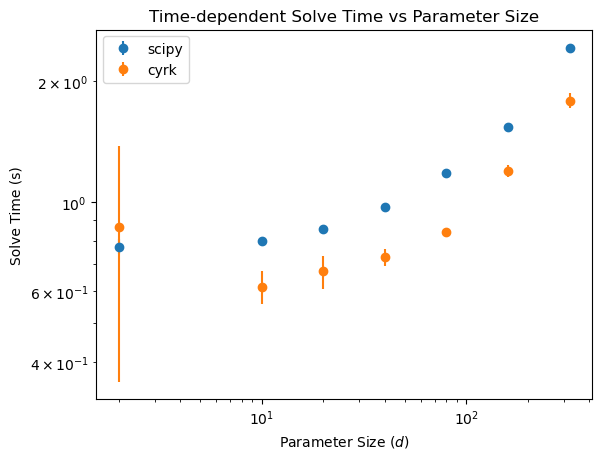

In [14]:
fig, ax = plt.subplots(1)

ave_times = ttimes_stack.mean(axis=1)
std_times = ttimes_stack.std(axis=1)

ax.errorbar(tsize, ave_times, yerr=std_times, fmt='o', label='scipy')
ax.errorbar(tsize, cttimes_stack.mean(axis=1), yerr=cttimes_stack.std(axis=1), fmt='o', label='cyrk')
ax.legend()
ax.set_title('Time-dependent Solve Time vs Parameter Size')
ax.set_xlabel('Parameter Size ($d$)')
ax.set_ylabel('Solve Time (s)')
ax.set_yscale('log')
ax.set_xscale('log')

## Comparison to qutip ##

While qutip primarily targets a different (and wider) set of problems, we can compare solving a simple 2-level system over a set of parameters. We note that qutip is not designed or advertised to be effective at solving semi-classical quantum systems with large numbers of atomic levels or iterated over many parameters. Rydiqule, on the other hand, is specifically designed to solve that subset of problems, as will be seen below.

First, we solve the demonstration system in rydiqule. It has 101 detunings and 10 rabi frequencies, and we want to plot the imaginary part of $\rho_{1,0}$.

In [15]:
detunings = np.linspace(-50, 50, 101)
rabis = np.geomspace(0.1, 25, 10)
gamma = 6.0666

probe = {'states': (0,1), 'rabi_frequency':2*np.pi*rabis, 'detuning':2*np.pi*detunings, 'label':'probe'}

s2 = rq.Sensor(2)
s2.add_couplings(probe)
s2.add_decoherence((1,0), 2*np.pi*gamma)

In [26]:
%%timeit
sols_rq2 = rq.solve_steady_state(s2)

13.4 ms ± 853 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0, 0.5, '$Im(\\rho_{1,0})$')

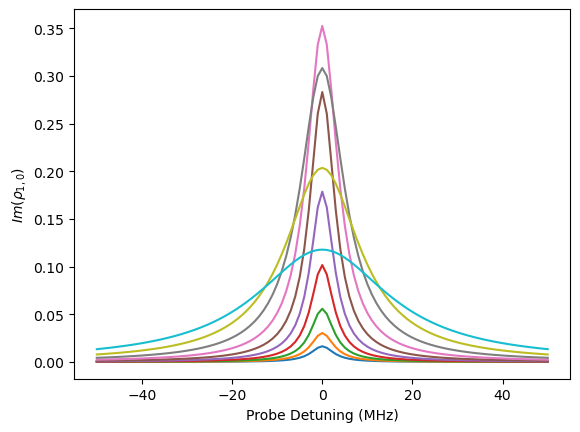

In [17]:
fig, ax = plt.subplots(1)

ax.plot(detunings, sols_rq2.rho_ij(1,0).imag)
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('$Im(\\rho_{1,0})$')

Constructing the same hamiltonian in qutip is done by expressing it as sums of Pauli matrices. Note that each parameter set requires re-building the Hamiltonian at each point, done via a nested python loop. It is difficult to scale the problem configuration to large numbers of atomic levels. And each set of parameters to be iterated over requires a separate python loop. The incurred interpreter overhead is substantial, giving a solve time more than 3 orders of magnitude slower.

In [18]:
import qutip

In [19]:
sm = qutip.sigmam()
c_op_list = [gamma * sm] # note: 2pi is added by qutip

psi0 = qutip.basis(2, 0)
psi1 = qutip.basis(2, 1)

def q_solve(det, rabi):

    H0 = (2*np.pi*det*qutip.sigmaz() + 2*np.pi*rabi*qutip.sigmax())/2

    rho_ss = qutip.steadystate(H0, c_op_list, method='direct', solver='solve').full()

    return rho_ss


In [20]:
%%time
sols_qtp = np.empty((len(detunings), len(rabis), 2, 2), dtype = np.complex128)

for i, det in enumerate(detunings):
    for j, rabi in enumerate(rabis):
        sols_qtp[i,j] = q_solve(det, rabi)

CPU times: total: 20.1 s
Wall time: 20.2 s


Text(0, 0.5, '$Im(\\rho_{1,0})$')

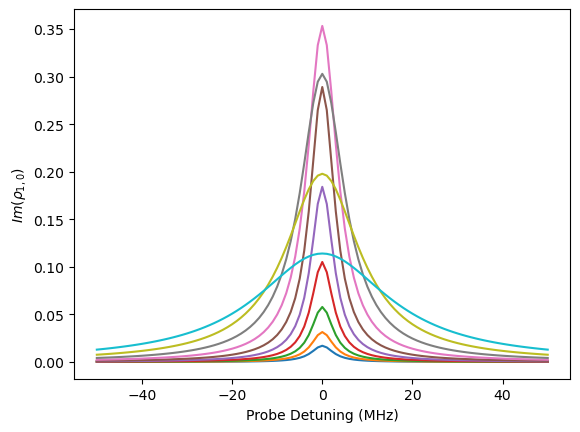

In [21]:
fig, ax = plt.subplots(1)

ax.plot(detunings, sols_qtp[:,:,1,0].imag)
ax.set_xlabel('Probe Detuning (MHz)')
ax.set_ylabel('$Im(\\rho_{1,0})$')

In [22]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.1.1.dev37
Installation Path:    ~\src\rydiqule_public\src\rydiqule

      Dependencies
    
NumPy Version:        2.0.1
SciPy Version:        1.16.0
Matplotlib Version:   3.10.5
ARC Version:          3.9.0
Python Version:       3.12.3
Python Install Path:  ~\miniconda3\envs\qutip
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB


In [23]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.1
Numpy Version:      2.0.1
Scipy Version:      1.16.0
Cython Version:     3.1.3
Matplotlib Version: 3.10.5
Python Version:     3.12.3
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\naqsL\miniconda3\envs\qutip\Lib\site-packages\qutip

Installed QuTiP family packages
-------------------------------

No QuTiP family packages installed.

Please